# Reimplementing CanICA with sklearn


In [1]:
%matplotlib inline

In [2]:
from nilearn import datasets
adhd_dataset = datasets.fetch_adhd(n_subjects=30,data_dir='/home/share/TmpData/Qinglin/nilearn_data/')
func_filenames = adhd_dataset.func  # list of 4D nifti files for each subject

# print basic information on the dataset
print('First functional nifti image (4D) is at: %s' %
      func_filenames[0])  # 4D data

/home/uga_qinglin/Documents/nilearn-extenstion/nilearn/datasets/func.py:503: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


First functional nifti image (4D) is at: /home/share/TmpData/Qinglin/nilearn_data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz


In [3]:
from nilearn._utils.niimg_conversions import _resolve_globbing
imgs = _resolve_globbing(func_filenames)

In [4]:
from nilearn.masking import compute_epi_mask
mask_img = compute_epi_mask(func_filenames)

from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_img, 
                     standardize=True,
                     detrend=1,
                     smoothing_fwhm=6.,
                     memory="/storage/nilearn_cache", 
                     memory_level=2)
fmri_masked = masker.fit()

In [5]:
from nilearn.decomposition.base import mask_and_reduce

data = mask_and_reduce(
    masker, imgs, confounds=None,
    reduction_ratio=0.1,
    random_state=0,
    memory="/storage/nilearn_cache",
    memory_level=3,
    n_jobs=8)

In [1]:
from nilearn.decomposition import CanICA
canica = CanICA(mask=masker, n_components=20, smoothing_fwhm=6.,
                memory="nilearn_cache", memory_level=2,
                threshold=3., verbose=10, random_state=0)

from nilearn.decomposition.multi_pca import MultiPCA
components = MultiPCA._raw_fit(canica,data)
#canica._unmix_components(components)
#components_img = canica.components_img_

NameError: name 'masker' is not defined

In [33]:
print(components.shape)

(63782, 20)


In [34]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=30,
              random_state=0)
D=ica.fit_transform(components.T)


/usr/local/lib/python3.5/dist-packages/sklearn/decomposition/fastica_.py:305: UserWarning: n_components is too large: it will be set to 20
  warnings.warn('n_components is too large: it will be set to %s' % n_components)


In [35]:
print(ica.mixing_.shape)
print(ica.components_.shape)

(63782, 20)
(20, 63782)


In [37]:
components=ica.mixing_.T

In [38]:
test=components

In [39]:
components=test
from scipy import stats
#components=stats.zscore(components,axis=1)

import numpy as np
from scipy.stats import scoreatpercentile

abs_components = np.abs(components)
ratio=100. - (100. / len(components)) *3
threshold = scoreatpercentile(abs_components,ratio)
components[abs_components < threshold] = 0

for component in components:

    if np.sum(component > 0) < np.sum(component < 0):
        component *= -1

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


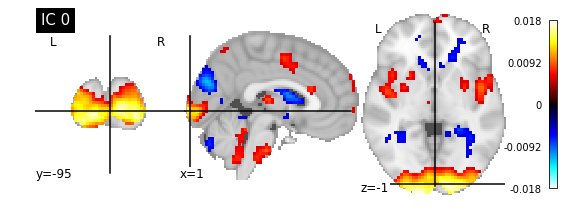

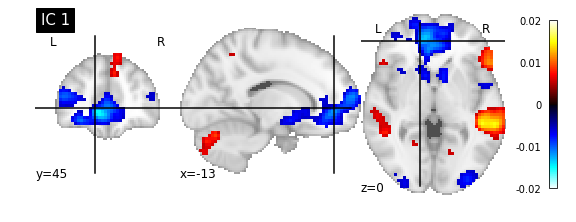

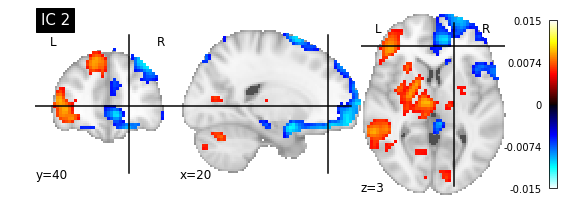

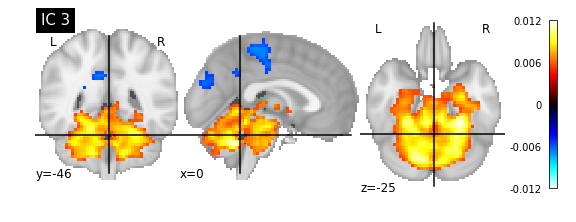

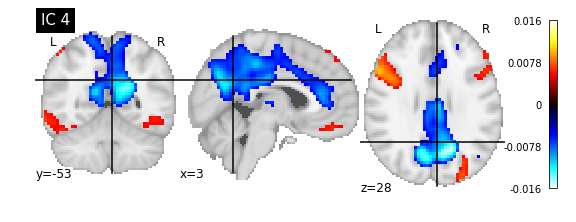

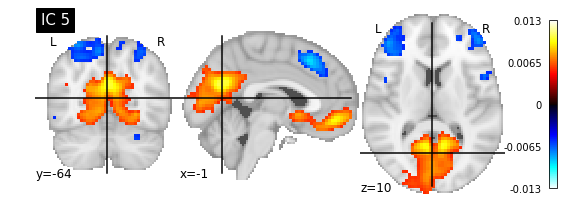

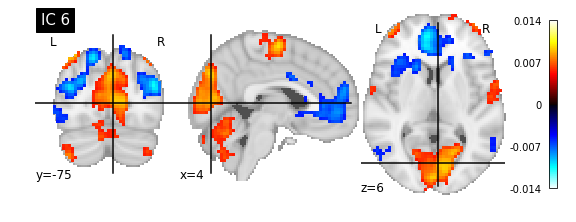

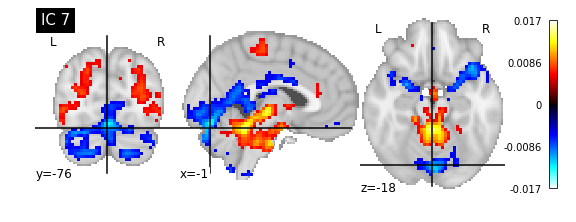

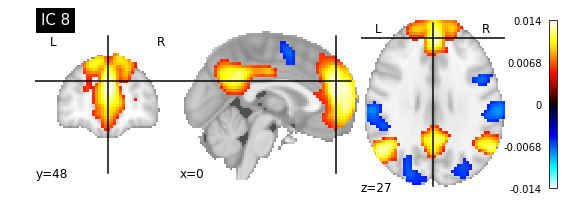

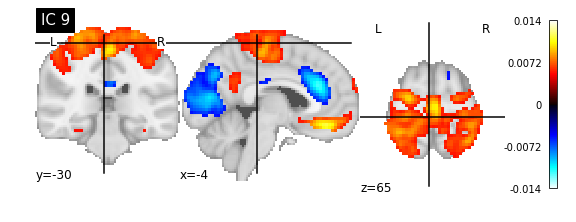

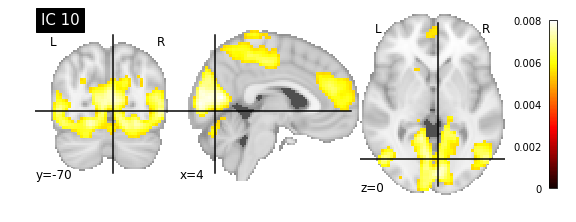

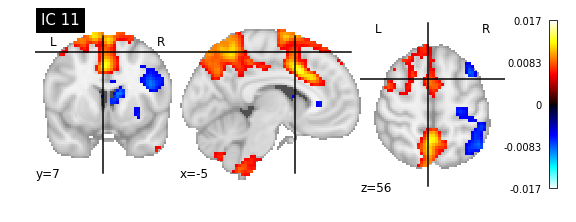

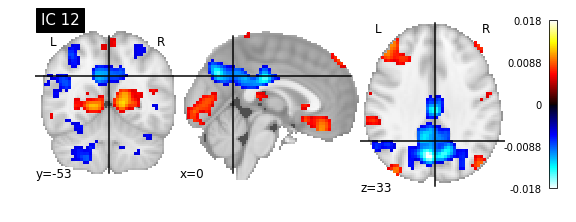

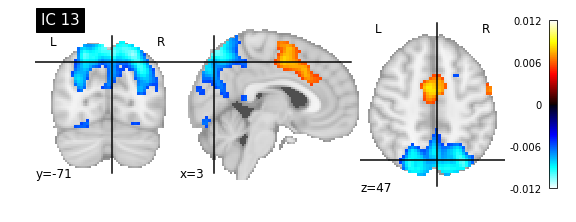

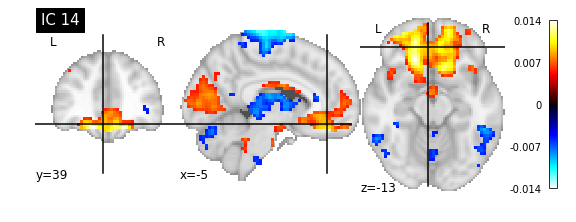

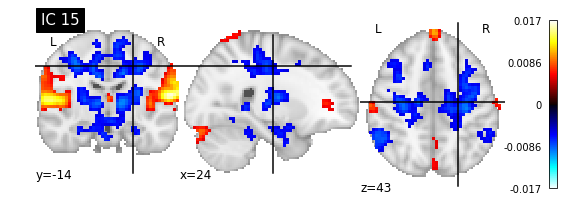

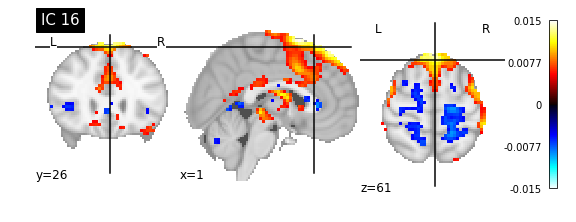

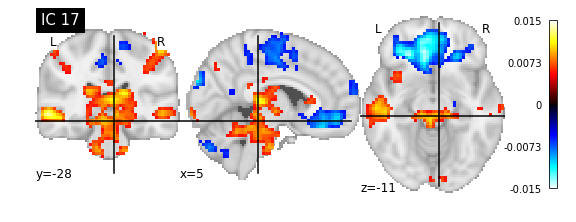

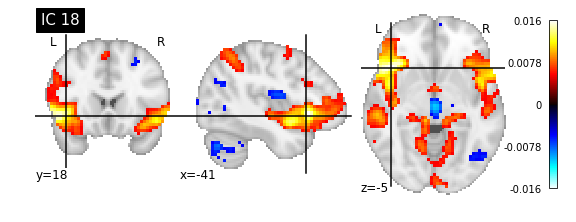

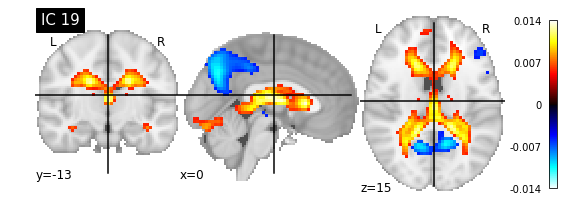

In [40]:
#components_img=[masker.inverse_transform(component) for component in components]
components_img=masker.inverse_transform(components)

from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(components_img)):
    plot_stat_map(cur_img, display_mode="ortho", title="IC %d" % i,
                  cut_coords=None, colorbar='bwr')

show()

/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:2785: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)
/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:942: UserWarning: linewidths is ignored by contourf
  warnings.warn('linewidths is ignored by contourf')


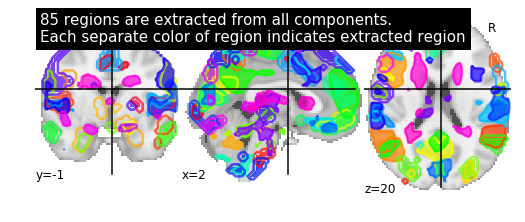

In [41]:
# Import Region Extractor algorithm from regions module
# threshold=0.5 indicates that we keep nominal of amount nonzero voxels across all
# maps, less the threshold means that more intense non-voxels will be survived.
from nilearn.regions import RegionExtractor

extractor = RegionExtractor(components_img, threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=5000)
# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

from nilearn.plotting import plot_prob_atlas
# Visualization of region extraction results
title = ('%d regions are extracted from %s components.'
         '\nEach separate color of region indicates extracted region'
         % (n_regions_extracted, 'all'))
plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title)